In [ ]:
from mosek.fusion import *
import mosek.fusion.pythonic
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Actually, I should just use np.ndindex instead

from itertools import product
def ranges(*args):
    if len(args) == 1:
        return range(args[0])
    else:
        return product(*[range(arg) for arg in args])

We are given a 16-dimensional variable $P$ (determined by a parameter $v$), defined as
$$P_v(ab\mid xy)=\frac14\left(1+(-1)^{a+b+xy}v\right).$$
Here, $a,b,e,x,y\in\left\{0,1\right\}$. Now, consider a 32-dimensional variable $Q$, consisting of $Q(abe\mid xy)$. Here are the constraints:
* Positivity: $Q(abe\mid xy)\geq0$.
* Compatibility: $$\sum_e Q(abe\mid xy)=P(ab\mid xy),\forall a,b,x,y.$$
* No-signalling $x\not\to be$: $$\sum_{a}Q(abe\mid 0y)=\sum_{a}Q(abe\mid 1y),\forall b,e,y.$$
* No-signalling $y\not\to ae$: $$\sum_{b}Q(abe\mid x0)=\sum_{b}Q(abe\mid x1),\forall a,e,x.$$
We want to maximize
$$Q(e=a\mid x=0)=\sum_{a,b}Q(aba\mid 0y)=\sum_{a,b}Q(aba\mid 00),$$
where $y$ can be chosen arbitrarily due to no-signalling $y\not\to ae$.

In [53]:
def P_v(v):
    arr = np.zeros((2, 2, 2, 2))
    for (a,b,x,y) in ranges(2,2,2,2):
        arr[x, y, a, b] = (1 + v * (-1)**(a + b + x * y)) / 4
    return arr

In [54]:
def eve(v):
    p = P_v(v)
    with Model("pedro") as M:
        q = M.variable("q", [2]*5, Domain.greaterThan(0.0)) # Positivity
        # Compatibility
        for (a,b,x,y) in ranges(2,2,2,2):
            M.constraint(sum([q[x,y,a,b,e] for e in range(2)]) == p[x, y, a, b])
        # No-signalling x to be
        for (b,e,y) in ranges(2,2,2):
            M.constraint(sum([(-1)**x * q[x,y,a,b,e] for (x,a) in ranges(2,2)]) == 0)
        # No-signalling y to ae
        for (a,e,x) in ranges(2,2,2):
            M.constraint(sum([(-1)**y * q[x,y,a,b,e] for (y,b) in ranges(2,2)]) == 0)
        M.objective("obj", ObjectiveSense.Maximize, sum([q[0,0,a,b,a] for (a,b) in ranges(2,2)]))
        M.solve()
        return M.primalObjValue()

In [55]:
vs = np.linspace(0, 1, 51)
evs = np.array([eve(v) for v in tqdm(vs)])

  0%|          | 0/51 [00:00<?, ?it/s]

Text(0, 0.5, '$\\max\\left(Q(e=a\\mid x=0)\\right)$')

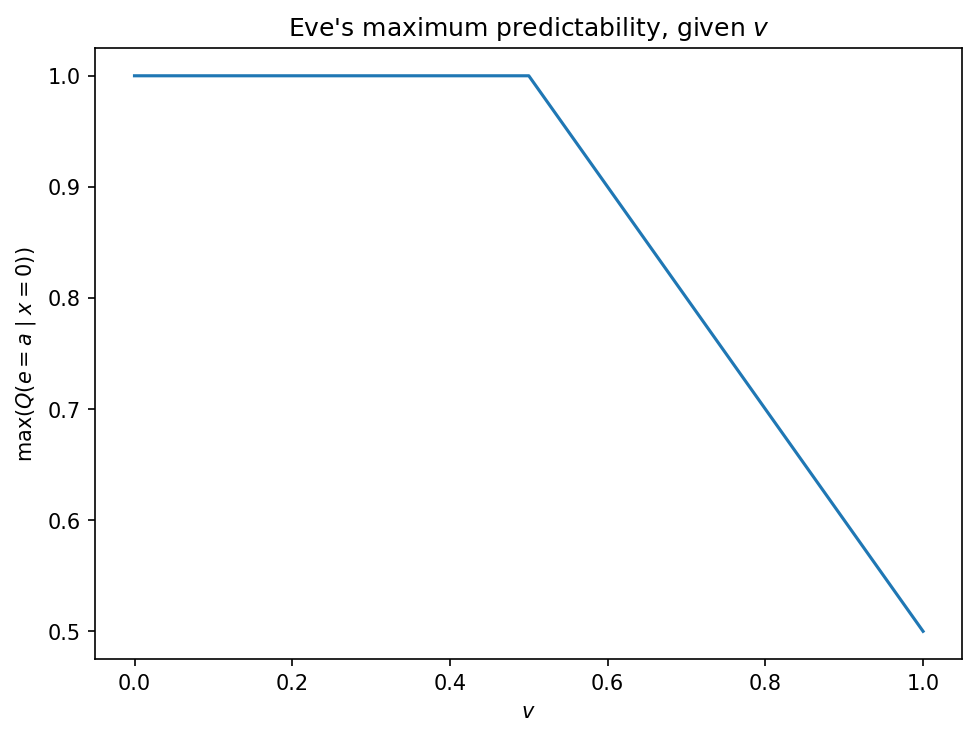

In [56]:
plt.subplots(dpi = 150, layout = "constrained")
plt.plot(vs, evs)
plt.title("Eve's maximum predictability, given $v$")
plt.xlabel("$v$")
plt.ylabel(r"$\max\left(Q(e=a\mid x=0)\right)$")

Now, we let the distribution $P(a,b\mid x,y)$ be free, but we constrain the CHSH score, defined as
$$\mathrm{CHSH}=\langle A_0B_0\rangle+\langle A_0B_1\rangle+\langle A_1B_0\rangle-\langle A_1B_1\rangle,$$
where
$$\langle A_xB_y\rangle:=P(a=b\mid x,y)-P(a\neq b\mid x,y).$$
Of course, we must also enforce normalization for $P$,
$$\sum_{a,b}P(a,b\mid x,y)=1,\forall x,y.$$
Note that the CHSH score for $P_v$ is $4v$.

In [57]:
def corr(p, x, y):
    return sum((-1)**(a + b) * p[x, y, a, b] for (a,b) in ranges(2,2))

In [58]:
with Model("pedro") as M:
    q = M.variable("q", [2]*5, Domain.greaterThan(0.0)) # Positivity
    p = M.variable("p", [2]*4, Domain.greaterThan(0.0)) # Positivity
    # Normalization
    for (x,y) in ranges(2,2):
        M.constraint(sum([p[x, y, a, b] for (a,b) in ranges(2,2)]) == 1)
    # CHSH
    M.constraint(sum([(-1)**(x * y) * corr(p, x, y) for (x,y) in ranges(2,2)]) <= 2)
    # Compatibility
    for (a,b,x,y) in ranges(2,2,2,2):
        M.constraint(sum([q[x,y,a,b,e] for e in range(2)]) == p[x, y, a, b])
    # No-signalling x to be
    for (b,e,y) in ranges(2,2,2):
        M.constraint(sum([(-1)**x * q[x,y,a,b,e] for (x,a) in ranges(2,2)]) == 0)
    # No-signalling y to ae
    for (a,e,x) in ranges(2,2,2):
        M.constraint(sum([(-1)**y * q[x,y,a,b,e] for (y,b) in ranges(2,2)]) == 0)
    M.objective("obj", ObjectiveSense.Maximize, sum([q[0, 0, a, e, a] for (a,e) in ranges(2,2)]))
    M.solve()
    print(p.level().reshape(2,2,2,2))
    # print(q.level().reshape(2,2,2,2,2))
    print(M.primalObjValue())

[[[[ 1.00000001e+00 -0.00000000e+00]
   [-0.00000000e+00 -7.93941259e-09]]

  [[ 1.00000001e+00 -0.00000000e+00]
   [-7.93941259e-09 -0.00000000e+00]]]


 [[[ 1.00000001e+00 -7.93941259e-09]
   [-0.00000000e+00 -0.00000000e+00]]

  [[ 1.00000000e+00 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00]]]]
1.0


In [66]:
def eve_chsh(chsh):
    with Model("pedro") as M:
        q = M.variable("q", [2]*5, Domain.greaterThan(0.0)) # Positivity
        p = M.variable("p", [2]*4, Domain.greaterThan(0.0)) # Positivity
        # Normalization
        for (x,y) in ranges(2,2):
            M.constraint(sum([p[x, y, a, b] for (a,b) in ranges(2,2)]) == 1)
        # CHSH
        M.constraint(sum([(-1)**(x * y) * corr(p, x, y) for (x,y) in ranges(2,2)]) == chsh)
        # Compatibility
        for (a,b,x,y) in ranges(2,2,2,2):
            M.constraint(sum([q[x,y,a,b,e] for e in range(2)]) == p[x, y, a, b])
        # No-signalling x to be
        for (b,e,y) in ranges(2,2,2):
            M.constraint(sum([(-1)**x * q[x,y,a,b,e] for (x,a) in ranges(2,2)]) == 0)
        # No-signalling y to ae
        for (a,e,x) in ranges(2,2,2):
            M.constraint(sum([(-1)**y * q[x,y,a,b,e] for (y,b) in ranges(2,2)]) == 0)
        M.objective("obj", ObjectiveSense.Maximize, sum([q[0, 0, a, e, a] for (a,e) in ranges(2,2)]))
        M.solve()
        # print(p.level().reshape(2,2,2,2))
        # print(q.level().reshape(2,2,2,2,2))
        return M.primalObjValue()

In [67]:
chshs = np.linspace(0, 4, 101)
evs_chsh = np.array([eve_chsh(chsh) for chsh in tqdm(chshs)])

  0%|          | 0/101 [00:00<?, ?it/s]

Text(0, 0.5, '$\\max\\left(Q(e=a\\mid x=0)\\right)$')

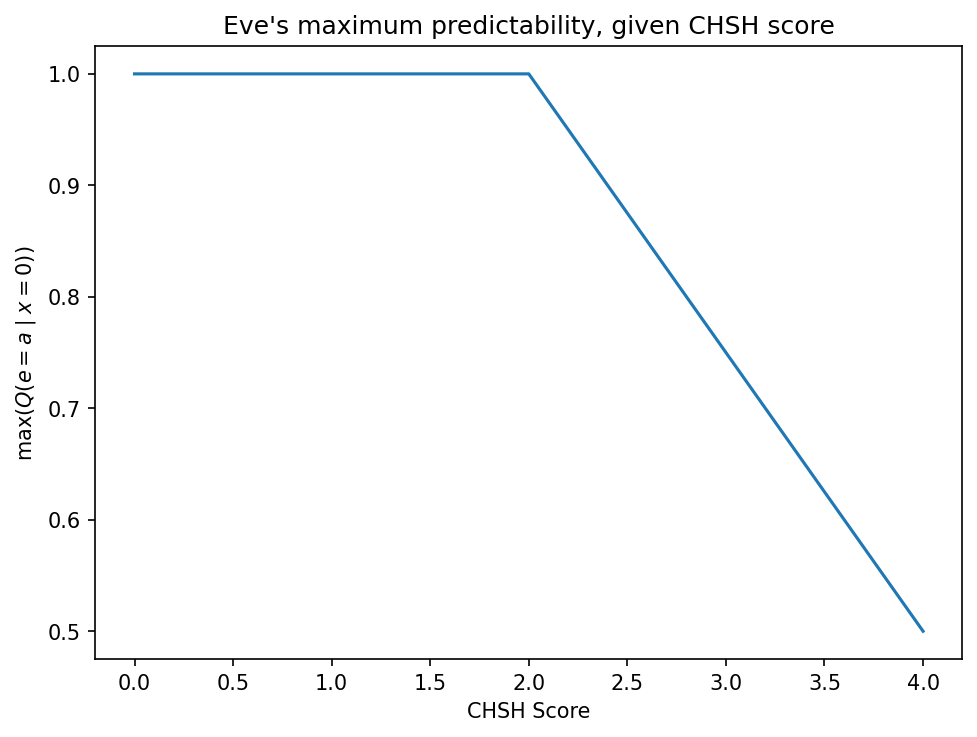

In [68]:
plt.subplots(dpi = 150, layout = "constrained")
plt.plot(chshs, evs_chsh)
plt.title("Eve's maximum predictability, given CHSH score")
plt.xlabel("CHSH Score")
plt.ylabel(r"$\max\left(Q(e=a\mid x=0)\right)$")

The new proposal is to look at $P_{\text{guess}}(e=b\mid x,y,a)$.

In [69]:
PR = np.array([[0.5*np.eye(2), 0.5*np.eye(2)],[0.5*np.eye(2), 0.5*np.array([[0,1],[1,0]])]])
PR

array([[[[0.5, 0. ],
         [0. , 0.5]],

        [[0.5, 0. ],
         [0. , 0.5]]],


       [[[0.5, 0. ],
         [0. , 0.5]],

        [[0. , 0.5],
         [0.5, 0. ]]]])

In [ ]:
with Model("pedro2") as M:
    N_A = 2
    N_B = 2
    N_W = 4
    q = M.variable("q", [N_A,N_B,N_W,N_A,N_B,N_A,N_B], Domain.greaterThan(0.0)) # Positivity
    # q[x, y, W, a, b, ea, eb]
    # Compatibility
    for (a,b,x,y,w) in ranges(N_A,N_B,N_A,N_B,N_W):
        M.constraint(sum([q[x,y,w,a,b,ea,eb] for (ea,eb) in ranges(N_A,N_B)]) == PR[x,y,a,b])
    
    # No-signalling x to be
    for (y,b,ea,eb,w) in ranges(N_B,N_B,N_A,N_B,N_W):
        base = sum([q[0,y,w,a,b,ea,eb] for a in range(N_A)])
        for x in range(1, N_A):
            M.constraint(base == sum([q[x,y,w,a,b,ea,eb] for a in range(N_A)]))
    
    # No-signalling y to ae
    for x,a,ea,eb,w in ranges(N_A,N_A,N_A,N_B,N_W):
        base = sum([q[x,0,w,a,b,ea,eb] for b in range(N_B)])
        for y in range(1, N_B):
            M.constraint(base == sum([q[x,y,w,a,b,ea,eb] for b in range(N_B)]))
    # Eve knows y = 0 and a. Eve guesses b. Set x = 0 because of no-signalling x to be.
    M.objective("obj", ObjectiveSense.Maximize, sum([q[0,0,0*2+a,a,b,ea,b] for (a,b,ea) in ranges(N_A,N_B,N_A)]))
    M.solve()
    # print(q.level().reshape([N_A,N_B,N_W,N_A,N_B,N_A,N_B]))
    print(M.primalObjValue())

1.0


In [73]:
table_3 = np.array([[0.25,0,0.25,0.5,0,0,0.5,0,0],[0,0.25,0,0,0.25,0,0,0.25,0],[0.25,0,0,0,0,0.25,0,0,0.25],[0.5,0,0,0.25,0.25,0,0.25,0,0.25],[0,0.25,0,0.25,0,0,0.25,0,0],[0,0,0.25,0,0,0.25,0,0.25,0],[0.5,0,0,0.25,0.25,0,0,0.25,0.25],[0,0.25,0,0.25,0,0,0.25,0,0],[0,0,0.25,0,0,0.25,0.25,0,0]])
P = np.zeros((3, 3, 3, 3))
for (i,j) in ranges(3,3):
    P[i, j] = table_3[3*i:3*i+3, 3*j:3*j+3]

In [74]:
with Model("pedro3") as M:
    N_A = 3
    N_B = 3
    N_W = 3
    q = M.variable("q", [N_A,N_B,N_W,N_A,N_B,N_A,N_B], Domain.greaterThan(0.0)) # Positivity
    # q[x, y, W, a, b, ea, eb]
    # Compatibility
    for (a,b,x,y,w) in ranges(N_A,N_B,N_A,N_B,N_W):
        M.constraint(sum([q[x,y,w,a,b,ea,eb] for (ea,eb) in ranges(N_A,N_B)]) == P[x,y,a,b])
    
    # No-signalling x to be
    for (y,b,ea,eb,w) in ranges(N_B,N_B,N_A,N_B,N_W):
        base = sum([q[0,y,w,a,b,ea,eb] for a in range(N_A)])
        for x in range(1, N_A):
            M.constraint(base == sum([q[x,y,w,a,b,ea,eb] for a in range(N_A)]))
    
    # No-signalling y to ae
    for x,a,ea,eb,w in ranges(N_A,N_A,N_A,N_B,N_W):
        base = sum([q[x,0,w,a,b,ea,eb] for b in range(N_B)])
        for y in range(1, N_B):
                M.constraint(base == sum([q[x,y,w,a,b,ea,eb] for b in range(N_B)]))
    # Eve knows y = 0. Eve guesses b. Set x = 0 because of no-signalling x to be.
    M.objective("obj", ObjectiveSense.Maximize, sum([q[0,0,0,a,b,ea,b] for (a,b,ea) in ranges(N_A,N_B,N_A)]))
    M.solve()
    # print(q.level().reshape([N_A,N_B,N_W,N_A,N_B,N_A,N_B]))
    print(M.primalObjValue())

0.5
